In [42]:
# Traffic prediction ML project
# Imports
import pandas as pd
import numpy as np
import sklearn as sc


In [43]:
'''
Feature engineering notes:
    - Time and date
    - Combine Vehicle continuing direction and vehicle going direction. Oncoming/incoming or same direction
    - The weather and surface cond columns may help each other...
    - Modify Light so that we replace 'Dark -- Unknown Lighting' with 'Dark'
    
'''

"\nFeature engineering notes:\n    - Time and date\n    - Combine Vehicle continuing direction and vehicle going direction. Oncoming/incoming or same direction\n    - The weather and surface cond columns may help each other...\n    - Modify Light so that we replace 'Dark -- Unknown Lighting' with 'Dark'\n    \n"

# Data Exploration

In [44]:
data = pd.read_csv("traffic.csv", na_values=['Unknown', 'None', 'UNKNOWN'])

/var/folders/xp/ph5sj5y90_j0747lx52mp81r0000gn/T/ipykernel_8364/576206584.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("traffic.csv", na_values=['Unknown', 'None', 'UNKNOWN'])


In [45]:
# data.shape - 172,105 rows, 43 columns

data['Collision Type'].value_counts()
# 12% other, 717 unknown. We may want to use similar-case imputation

data['Non-Motorist Substance Abuse'].value_counts()
# There are only ~200 data points that actually had substance abuse, so this should be dropped.

data['Driver Distracted By'].value_counts()
# 1/5th of the dataset is missing, over half has drivers that were not distracted. Maybe there's a correlation between distracted driving and severity? Maybe we can train a subset of the data on this to reveal more interesting patterns. Or, we could inject and say that half of the missing is distracted and the other half is not distracted. Or, maybe we should just drop it.

data['Drivers License State'].value_counts()
# correlation between driving out of state lines and being at fault? are drivers closer to home truly more likely to get in an accident? Outliers - FM, NS, MP, SK, etc.

data['Vehicle Movement'].value_counts()
# We need to get creative with our encoding, such as moving quickly, moving at a slower rate, or manuvering (parking, passing, turning, etc)

# This is our class label. We need to OHC different categories.
data['Injury Severity'].value_counts()
# the majority of the dataset isn't injured, fortunately.
# we will just keep the 5 predictors
    # No injury
    # Possible
    # Minor
    # Serious
    # Fatal :(
    
# Driver at fault was dropped because we don't think that the insurance/civil claim really determines how bad the accident is.
# An accident is an accident.
    
# data['Off-Road Description'].unique() # Determine that the values in this column is not important
# data['Driverless Vehicle'].unique() # No driverless vehicles, so column is unneeded
# data['Parked Vehicle'].value_counts() # 2,600 parked vehicles got an in accident. Might be interesting to see if there's a correlation between that and the severity of the accident.
# data['Related Non-Motorist'].value_counts() - There's only about 5000 fields here, it may be too little to make a discernible impact on the dataset.

# Look into what the cross street and route type means
# DROP Report Number, Local Case Number, Off-road description, Road name, Cross-street name, Driverless Vehicle, Municipality (many missing values),  
# Related Non-Motorist, Non-Motorist Substance Abuse, Person ID, Circumstance (??), Vehicle ID, Vehicle Make, Vehicle Model, Equiptment Problems, Location (as it combines Lat & Long)

Injury Severity
NO APPARENT INJURY          141185
POSSIBLE INJURY              17482
SUSPECTED MINOR INJURY       11870
SUSPECTED SERIOUS INJURY      1415
FATAL INJURY                   153
Name: count, dtype: int64

## Injury Severity Class Labels is Heavily Imbalanced
Consider oversampling techniques when building models to balance data.

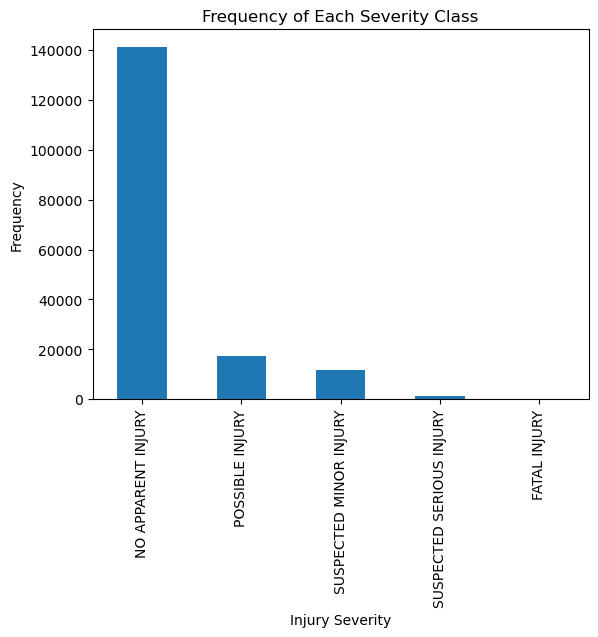

In [46]:
import matplotlib.pyplot as plt

severity_counts = data['Injury Severity'].value_counts()
severity_counts.plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Frequency of Each Severity Class')

# Show plot
plt.show()

# Data Cleaning
## Part 1: Removing unneeded rows

In [47]:
# Feature engineer new columns "Vehicle Dir Changed" and "Vehicle Multiple Impacts"
data['Vehicle Dir Changed'] = np.where(data['Vehicle Continuing Dir'] == data['Vehicle Going Dir'], 'No', 'Yes')
data['Vehicle Multiple Impacts'] = np.where(data['Vehicle First Impact Location'] == data['Vehicle Second Impact Location'], 'No', 'Yes')
#Drop unnecessary data columns
data = data.drop(columns = ['Agency Name', 'Report Number', 'Local Case Number', 'Off-Road Description', 'Road Name', 'Cross-Street Name', 'Driverless Vehicle', 'Municipality', 'Non-Motorist Substance Abuse', 'Person ID', 'Circumstance', 'Vehicle ID', 'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Location','Driverless Vehicle', 'Vehicle Continuing Dir', 'Vehicle Going Dir', 'Route Type', 'Vehicle First Impact Location', 'Vehicle Second Impact Location', 'Related Non-Motorist', 'Drivers License State'], axis = 1)

## Part 2: Feature engineering
### Dealing with the Date/Time column
We want to extrapolate out patterns from the data and time columns.
It would be difficult to train on that column as a whole, but separately it 
can extract out useful patterns.

In [48]:
data.loc[data['Weather'] == 'RAINING', 'Light'] = data.loc[data['Weather'] == 'RAINING', 'Light'].fillna('DARK')
data.loc[data['Weather'] == 'FOGGY', 'Light'] = data.loc[data['Weather'] == 'FOGGY', 'Light'].fillna('DARK')

import datetime
new_weekdays = []
pos = 0
count = 0
for i, date in data['Crash Date/Time'].items() : 
    date_parsed = date.split(' ')
    time = date_parsed[0].split('/')
    obj = datetime.datetime(int(time[2]), int(time[0]), int(time[1]))
    new_weekdays.append(obj.weekday())
    hour = int(date_parsed[1].split(':')[0])

    if pd.isnull(data['Light'][i]) :
        if (hour < 5 or hour > 22) : 
            data['Light'][i] = 'DARK'
        elif (hour >= 5 and hour <= 8): 
            data['Light'][i] = 'DAWN' 
        elif (hour > 8 and hour <= 15) : 
            data['Light'][i] = 'LIGHT'
        elif (hour > 15 and hour <= 22) : 
            data['Light'][i] = 'DUSK'
            
data['Crash Date/Time'] = new_weekdays
# df_encoded = pd.get_dummies(data['Crash Date/Time'], columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# data = pd.concat([data, df_encoded] , axis=1)
# data = data.drop(columns=['Crash Date/Time'])

# This reduces surface cond. NA/s by about 16,000
data.loc[data['Weather'] == 'CLEAR', 'Surface Condition'] = data.loc[data['Weather'] == 'CLEAR', 'Surface Condition'].fillna('DRY')
data.loc[data['Weather'] == 'RAINING', 'Surface Condition'] = data.loc[data['Weather'] == 'RAINING', 'Surface Condition'].fillna('WET')
# It should be safe to drop the rest. 
data.dropna(subset=['Surface Condition'], inplace=True)


data['Surface Condition'].value_counts()
data = data.drop(columns=['Weather'])

data.head()


/var/folders/xp/ph5sj5y90_j0747lx52mp81r0000gn/T/ipykernel_8364/3725189850.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Light'][i] = 'DARK'
/var/folders/xp/ph5sj5y90_j0747lx52mp81r0000gn/T/ipykernel_8364/3725189850.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Light'][i] = 'DARK'
/var/folders/xp/ph5sj5y90_j0747lx52mp81r0000gn/T/ipykernel_8364/3725189850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat

,ACRS Report Type,Crash Date/Time,Cross-Street Type,Collision Type,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Driver At Fault,Injury Severity,...,Vehicle Damage Extent,Vehicle Body Type,Vehicle Movement,Speed Limit,Parked Vehicle,Vehicle Year,Latitude,Longitude,Vehicle Dir Changed,Vehicle Multiple Impacts
0,Property Damage Crash,4,NaN,OTHER,DRY,DAYLIGHT,NaN,NaN,Yes,NO APPARENT INJURY,...,SUPERFICIAL,PASSENGER CAR,PARKING,15,No,2004,39.150044,-77.063089,No,No
1,Property Damage Crash,4,NaN,STRAIGHT MOVEMENT ANGLE,DRY,DAYLIGHT,TRAFFIC SIGNAL,NONE DETECTED,No,NO APPARENT INJURY,...,DISABLING,PASSENGER CAR,MAKING LEFT TURN,40,No,2011,39.159264,-77.219025,Yes,Yes
2,Property Damage Crash,3,Maryland (State),STRAIGHT MOVEMENT ANGLE,DRY,DAYLIGHT,TRAFFIC SIGNAL,NONE DETECTED,Yes,NO APPARENT INJURY,...,FUNCTIONAL,PICKUP TRUCK,ACCELERATING,35,No,2019,39.109535,-77.075806,No,No
3,Property Damage Crash,6,County,STRAIGHT MOVEMENT ANGLE,DRY,DAYLIGHT,NO CONTROLS,NONE DETECTED,Yes,NO APPARENT INJURY,...,FUNCTIONAL,PASSENGER CAR,STARTING FROM LANE,40,No,2016,39.190149,-77.266766,No,No
4,Property Damage Crash,0,County,HEAD ON LEFT TURN,DRY,DAYLIGHT,TRAFFIC SIGNAL,NONE DETECTED,Yes,NO APPARENT INJURY,...,FUNCTIONAL,(SPORT) UTILITY VEHICLE,MAKING LEFT TURN,35,No,2016,39.172558,-77.203745,Yes,No


### Map out ACRS Report Type to numerical 

In [49]:
data['ACRS Report Type'] = data['ACRS Report Type'].map({'Property Damage Crash': 0, 'Injury Crash': 1, 'Fatal Crash': 2})
data['Vehicle Dir Changed'] = data['Vehicle Dir Changed'].map({'No': 0, 'Yes': 1})
data['Vehicle Multiple Impacts'] = data['Vehicle Multiple Impacts'].map({'No': 0, 'Yes': 1})

data['ACRS Report Type'].value_counts()

ACRS Report Type
0    104989
1     61097
2       423
Name: count, dtype: int64

### Reducing varation on the features for the Substance Abuse column
#### Group into the following classes
    * Alcohol
    * Illicit Drug
    * Medication
    * None Present

In [50]:
# We are assuming that since the officer did not record any alcohol or drugs, 
# that the driver was not under the influence.

data['Driver Substance Abuse'].fillna('NONE DETECTED', inplace=True)
data['Driver Substance Abuse'].replace('ALCOHOL CONTRIBUTED', 'ALCOHOL', inplace=True)
data['Driver Substance Abuse'].replace('ALCOHOL PRESENT', 'ALCOHOL', inplace=True)
data['Driver Substance Abuse'].replace('ILLEGAL DRUG PRESENT', 'ILLICIT DRUG', inplace=True)
data['Driver Substance Abuse'].replace('ILLEGAL DRUG CONTRIBUTED', 'ILLICIT DRUG', inplace=True)
data['Driver Substance Abuse'].replace('COMBINATION PRESENT', 'ILLICIT DRUG', inplace=True)
data['Driver Substance Abuse'].replace('COMBINATION CONTRIBUTED', 'ILLICIT DRUG', inplace=True)
data['Driver Substance Abuse'].replace('COMBINED SUBSTANCE PRESENT', 'ILLICIT DRUG', inplace=True)
data['Driver Substance Abuse'].replace('MEDICATION PRESENT', 'MEDICATION', inplace=True)
data['Driver Substance Abuse'].replace('MEDICATION CONTRIBUTED', 'MEDICATION', inplace=True)
data['Driver Substance Abuse'].replace('OTHER', 'NONE DETECTED', inplace=True)

### Reducing variation on Traffic Control

In [51]:
data['Traffic Control'].replace('STOP SIGN', 'SIGN', inplace=True)
data['Traffic Control'].replace('FLASHING TRAFFIC SIGNAL', 'SIGN', inplace=True)
data['Traffic Control'].replace('YIELD SIGN', 'SIGN', inplace=True)
data['Traffic Control'].replace('OTHER', 'SIGN', inplace=True)
data['Traffic Control'].replace('PERSON', 'TRAFFIC SIGNAL', inplace=True)
data['Traffic Control'].replace('WARNING SIGN', 'SIGN', inplace=True)
data['Traffic Control'].replace('RAILWAY CROSSING DEVICE', 'SIGN', inplace=True)
data['Traffic Control'].replace('SCHOOL ZONE SIGN DEVICE', 'SIGN', inplace=True)

data['Traffic Control'].value_counts()

Traffic Control
NO CONTROLS       65978
TRAFFIC SIGNAL    58601
SIGN              18210
Name: count, dtype: int64

### Missing values on Collision Type

In [52]:
data['Collision Type'].fillna('OTHER', inplace=True)
data['Collision Type'].replace('SAME DIRECTION SIDESWIPE', 'SIDESWIPE', inplace=True)
data['Collision Type'].replace('OPPOSITE DIRECTION SIDESWIPE', 'SIDESWIPE', inplace=True)
data['Collision Type'].replace('SAME DIRECTION RIGHT TURN', 'TURNING', inplace=True)
data['Collision Type'].replace('ANGLE MEETS LEFT TURN', 'TURNING', inplace=True)
data['Collision Type'].replace('ANGLE MEETS RIGHT TURN', 'TURNING', inplace=True)
data['Collision Type'].replace('SAME DIR REND LEFT TURN', 'TURNING', inplace=True)
data['Collision Type'].replace('SAME DIR REND RIGHT TURN', 'TURNING', inplace=True)
data['Collision Type'].replace('SAME DIR BOTH LEFT TURN', 'TURNING', inplace=True)
data['Collision Type'].replace('OPPOSITE DIR BOTH LEFT TURN', 'HEAD ON', inplace=True)
data['Collision Type'].replace('HEAD ON LEFT TURN', 'HEAD ON', inplace=True)
data['Collision Type'].replace('ANGLE MEETS LEFT HEAD ON', 'HEAD ON', inplace=True)
data['Collision Type'].replace('SAME DIRECTION LEFT TURN', 'TURNING', inplace=True)

data['Collision Type'].value_counts()

Collision Type
SAME DIR REAR END          54915
STRAIGHT MOVEMENT ANGLE    29698
SIDESWIPE                  18461
OTHER                      18219
HEAD ON                    17420
SINGLE VEHICLE             15057
TURNING                    12739
Name: count, dtype: int64

In [53]:
# data['Vehicle Movement'].value_counts()
# We've decided to drop out the missing values here given that it's only 0.02% of the database
data.dropna(subset=['Vehicle Movement'], inplace=True)


### Vehicle body type

In [54]:
data['Vehicle Body Type'].fillna('OTHER', inplace=True)
data['Vehicle Body Type'].replace('PASSENGER CAR', 'CAR/SUV/NON-EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('FARM VEHICLE', 'CAR/SUV/NON-EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('LIMOUSINE', 'CAR/SUV/NON-EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('(SPORT) UTILITY VEHICLE', 'CAR/SUV/NON-EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('POLICE VEHICLE/NON EMERGENCY', 'CAR/SUV/NON-EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('STATION WAGON', 'CAR/SUV/NON-EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('PICKUP TRUCK', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('VAN', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('OTHER BUS', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('TRUCK TRACTOR', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('FIRE VEHICLE/NON EMERGENCY', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('AMBULANCE/NON EMERGENCY', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('TRANSIT BUS', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('CROSS COUNTRY BUS', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('SCHOOL BUS', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('RECREATIONAL VEHICLE', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('(SPORT) UTILITY VEHICLE', 'CAR/SUV/NON-EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))', 'VAN/TRUCK', inplace=True)
data['Vehicle Body Type'].replace('AMBULANCE/EMERGENCY', 'EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('FIRE VEHICLE/EMERGENCY', 'EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('POLICE VEHICLE/EMERGENCY', 'EMERGENCY', inplace=True)
data['Vehicle Body Type'].replace('MOPED', 'MOTORCYCLE', inplace=True)
data['Vehicle Body Type'].replace('ALL TERRAIN VEHICLE (ATV)', 'MOTORCYCLE', inplace=True)
data['Vehicle Body Type'].replace('SNOWMOBILE', 'MOTORCYCLE', inplace=True)
data['Vehicle Body Type'].replace('LOW SPEED VEHICLE', 'MOTORCYCLE', inplace=True)
data['Vehicle Body Type'].replace('AUTOCYCLE', 'MOTORCYCLE', inplace=True)

data['Vehicle Body Type'].isna().value_counts()

Vehicle Body Type
False    163785
Name: count, dtype: int64

### Vehicle Damage Extent

In [55]:
data['Vehicle Damage Extent'].isna().value_counts()
data['Vehicle Damage Extent'].value_counts()
data.dropna(subset=['Vehicle Damage Extent'], inplace=True)

data['Driver Distracted By'].isna().value_counts()

Driver Distracted By
False    133830
True      24749
Name: count, dtype: int64

### Driver Distracted By

In [56]:
data['Driver Distracted By'].replace('SMOKING RELATED', 'SUBSTANCE ABUSE', inplace=True)
data['Driver Distracted By'].replace('BY OTHER OCCUPANTS', 'MENTAL DISTRACTION', inplace=True)
data['Driver Distracted By'].replace('EATING OR DRINKING', 'HANDS OCCUPIED', inplace=True)
data['Driver Distracted By'].replace('BY MOVING OBJECT IN VEHICLE', 'MENTAL DISTRACTION', inplace=True)
data['Driver Distracted By'].replace('ADJUSTING AUDIO AND OR CLIMATE CONTROLS', 'HANDS OCCUPIED', inplace=True)
data['Driver Distracted By'].replace('USING OTHER DEVICE CONTROLS INTEGRAL TO VEHICLE', 'HANDS OCCUPIED', inplace=True)
data['Driver Distracted By'].replace('OTHER CELLULAR PHONE RELATED', 'HANDS OCCUPIED', inplace=True)
data['Driver Distracted By'].replace('OTHER ELECTRONIC DEVICE (NAVIGATIONAL PALM PILOT)', 'MENTAL DISTRACTION', inplace=True)
data['Driver Distracted By'].replace('TALKING OR LISTENING TO CELLULAR PHONE', 'MENTAL DISTRACTION', inplace=True)
data['Driver Distracted By'].replace('TEXTING FROM A CELLULAR PHONE', 'HANDS OCCUPIED', inplace=True)
data['Driver Distracted By'].replace('DIALING CELLULAR PHONE', 'HANDS OCCUPIED', inplace=True)
data['Driver Distracted By'].replace('USING DEVICE OBJECT BROUGHT INTO VEHICLE', 'HANDS OCCUPIED', inplace=True)

data['Driver Distracted By'].replace('LOOKED BUT DID NOT SEE', 'MENTAL DISTRACTION', inplace=True)
data['Driver Distracted By'].replace('INATTENTIVE OR LOST IN THOUGHT', 'MENTAL DISTRACTION', inplace=True)
data['Driver Distracted By'].replace('DISTRACTED BY OUTSIDE PERSON OBJECT OR EVENT', 'MENTAL DISTRACTION', inplace=True)

data['Driver Distracted By'].value_counts()

Driver Distracted By
NOT DISTRACTED        102918
MENTAL DISTRACTION     26716
OTHER DISTRACTION       3050
HANDS OCCUPIED           935
NO DRIVER PRESENT        187
SUBSTANCE ABUSE           24
Name: count, dtype: int64

### Vehicle Movement

In [57]:
data['Vehicle Movement'].replace('STARTING FROM PARKED', 'PARKING', inplace=True)
data['Vehicle Movement'].replace('STARTING FROM LANE', 'CHANGING LANES', inplace=True)
data['Vehicle Movement'].replace('ENTERING TRAFFIC LANE', 'CHANGING LANES', inplace=True)
data['Vehicle Movement'].replace('LEAVING TRAFFIC LANE', 'CHANGING LANES', inplace=True)

data['Vehicle Movement'].value_counts()

Vehicle Movement
MOVING CONSTANT SPEED      64055
SLOWING OR STOPPING        23613
STOPPED IN TRAFFIC LANE    17996
MAKING LEFT TURN           15964
CHANGING LANES              9556
ACCELERATING                8862
MAKING RIGHT TURN           5024
BACKING                     4192
PARKING                     2807
PARKED                      2316
MAKING U TURN               1167
PASSING                      818
OTHER                        758
SKIDDING                     669
NEGOTIATING A CURVE          508
RIGHT TURN ON RED            243
DRIVERLESS MOVING VEH.        31
Name: count, dtype: int64

### Vehicle Year

In [58]:
data = data[(data['Vehicle Year'] >= 1900) & (data['Vehicle Year'] <= 2024)]

### Speed Limit

In [59]:
data['Speed Limit'].replace({0: '<=25', 5: '<=25', 10: '<=25', 15: '<=25', 20: '<=25',25:'<=25'}, inplace=True)

data['Speed Limit'].replace({50: '>=50', 55: '>=50', 60: '>=50', 65: '>=50', 70: '>=50', 75: '>=50'}, inplace=True)

print(data['Speed Limit'].value_counts())

# <= 25: School / neighborhood range limit
# >= 50: Highway limit
# Other: 30, 35, 40, 45 (left alone)

Speed Limit
35      47538
<=25    35452
40      32076
30      21978
45      11873
>=50     8329
Name: count, dtype: int64


### Substance Abuse Null Values

In [60]:
data.loc[(data['Driver Substance Abuse'] != 'NONE DETECTED') & (data['Driver Distracted By'].isna()), 'Driver Distracted By'] = 'SUBSTANCE ABUSE'

# This could be very problamatic. It might not be a great indicator of distraction if the driver was at fault (i.e. road rage)
# Do the ML and see if it's good or not!!
data.loc[(data['Driver At Fault'] == 'Yes') & (data['Driver Distracted By'].isna()), 'Driver Distracted By'] = 'AT FAULT'

data.dropna(subset=['Driver Distracted By'], inplace=True)

data = data.drop(columns=['Driver At Fault'])

# After we've engineered the features into one, we can drop the distraction column.
data['Driver Distracted By'].value_counts()

Driver Distracted By
NOT DISTRACTED        102648
MENTAL DISTRACTION     26607
AT FAULT               18565
OTHER DISTRACTION       3036
SUBSTANCE ABUSE         2021
HANDS OCCUPIED           934
NO DRIVER PRESENT        174
Name: count, dtype: int64

In [61]:
data['same_dir'] = data['Vehicle Movement'].apply(lambda x: 1 if 'SAME' in x else 0)

### Attempt at using an API to interpret geographical data
Unfortunately, the API was too slow to be practically used on this size of data.

In [62]:
# import requests

# main_url = 'https://geocoding.geo.census.gov/geocoder/geographies/coordinates?'
# benchmark = 'Public_Ar_Census2020'
# format = 'JSON'
# vintage = 'Census2010_Census2020'
# data_sub = data[0:1]
# populations = []
# for i in data_sub.iterrows() :
#     test_x = i[1]['Longitude']
#     test_y = i[1]['Latitude']
#     response = requests.get(f"https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x={test_x}&y={test_y}&benchmark={benchmark}&format={format}&vintage={vintage}")
#     json = response.json()
#     populations.append(json['result']['geographies']['County Subdivisions'][0]['POP100'])


### Results of the data cleaning

In [63]:
print("final shape: ", data.shape)

# Given that we do not have geographical data, we decided to drop the N/A values for cross street type and traffic control.
# However, this was a rather significant chunk of the dataset. Given the large size, this shouldn't affect the results too much.
# It would probably be better to use geographical data to make predictions as to what street type/traffic control devices could be present.
# data = data.drop(columns = ['Cross-Street Type', 'Traffic Control'], axis = 1)

data.dropna(subset=['Cross-Street Type'], inplace=True)
data.dropna(subset=['Traffic Control'], inplace=True)

data.columns.astype(str)
# Verify that there are no missing values.
nulls = data.isnull()
nulls.mean(axis=0)

final shape:  (153985, 21)


ACRS Report Type            0.0
Crash Date/Time             0.0
Cross-Street Type           0.0
Collision Type              0.0
Surface Condition           0.0
Light                       0.0
Traffic Control             0.0
Driver Substance Abuse      0.0
Injury Severity             0.0
Driver Distracted By        0.0
Vehicle Damage Extent       0.0
Vehicle Body Type           0.0
Vehicle Movement            0.0
Speed Limit                 0.0
Parked Vehicle              0.0
Vehicle Year                0.0
Latitude                    0.0
Longitude                   0.0
Vehicle Dir Changed         0.0
Vehicle Multiple Impacts    0.0
same_dir                    0.0
dtype: float64

# Machine learning
## Part 1: Traditional models

In [64]:
# Machine Learning imports
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier


### Frequency Encoding
One hot encoding may result in the dataset having a very high dimensionality. For algorithms that suffer from the curse of dimensionality, it may be more practical to use another approach to encoding.

In [65]:
data['Injury Severity'] = data['Injury Severity'].map({'NO APPARENT INJURY': 0, 'POSSIBLE INJURY': 1, 'SUSPECTED MINOR INJURY': 2, 'SUSPECTED SERIOUS INJURY': 3, 'FATAL INJURY': 4})
labels = data['Injury Severity']
features = data.drop('Injury Severity', axis=1)

features_freq = features.copy()
for row in features_freq :
    print(row)
    i = features_freq.groupby(row).size() / len(features)
    features_freq[row] = features_freq[row].apply(lambda x : i[x])

ACRS Report Type
Crash Date/Time
Cross-Street Type
Collision Type
Surface Condition
Light
Traffic Control
Driver Substance Abuse
Driver Distracted By
Vehicle Damage Extent
Vehicle Body Type
Vehicle Movement
Speed Limit
Parked Vehicle
Vehicle Year
Latitude
Longitude
Vehicle Dir Changed
Vehicle Multiple Impacts
same_dir


### One-hot encoding
Many of the sklearn models require that the data be numerical. This may not be ideal (and may requrire significant dimensionality reduction), but we'll investigate that further.

In [66]:
features_ohe = pd.get_dummies(features)
X_train, X_test, Y_train, Y_test = train_test_split(features_ohe, labels, test_size=0.2)

features_ohe.head()

,ACRS Report Type,Crash Date/Time,Vehicle Year,Latitude,Longitude,Vehicle Dir Changed,Vehicle Multiple Impacts,same_dir,Cross-Street Type_County,Cross-Street Type_Government,...,Vehicle Movement_SLOWING OR STOPPING,Vehicle Movement_STOPPED IN TRAFFIC LANE,Speed Limit_30,Speed Limit_35,Speed Limit_40,Speed Limit_45,Speed Limit_<=25,Speed Limit_>=50,Parked Vehicle_No,Parked Vehicle_Yes
2,0,3,2019,39.109535,-77.075806,0,0,0,False,False,...,False,False,False,True,False,False,False,False,True,False
3,0,6,2016,39.190149,-77.266766,0,0,0,True,False,...,False,False,False,False,True,False,False,False,True,False
4,0,0,2016,39.172558,-77.203745,1,0,0,True,False,...,False,False,False,True,False,False,False,False,True,False
5,0,1,2016,38.994498,-77.027334,0,0,0,True,False,...,False,True,True,False,False,False,False,False,True,False
6,0,2,2014,39.008113,-77.020157,0,0,0,False,False,...,True,False,False,False,False,False,True,False,True,False


## Decision Tree

#### Frequency grouping

In [67]:
dt2 = DecisionTreeClassifier(criterion='entropy')

acc2 = cross_val_score(dt2, features_freq, labels, cv=5)
print("Accuracy: ", acc2.mean())
# Wooow, what a fantastic accuracy!

Accuracy:  0.777408406579062


#### One-hot encoding

In [68]:
dt = DecisionTreeClassifier(criterion='entropy')

# With 10-fold cross validation, Decision tree gets 79% accuracy
cvp = cross_val_predict(dt, features_ohe, labels, cv=5)

print(classification_report(labels, cvp))
# Oh no...

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     91858
           1       0.33      0.34      0.34     13088
           2       0.25      0.25      0.25      8906
           3       0.10      0.12      0.11      1004
           4       0.66      0.65      0.65        54

    accuracy                           0.78    114910
   macro avg       0.45      0.45      0.45    114910
weighted avg       0.78      0.78      0.78    114910



#### Quick analysis
The dataset is obviously skewed towards the `0 (no injury)` class, which represents no injury. This means that the precision, recall, and f-scores for that class are going to be great.  
*In fact*, 81.2% of the population predicts `no injury`. If I were to create a decision tree which is trained on identical data, it would get an accuracy of 81.2%. **This is not good.**
##### The issue
We want our model to accurately predict the *other* injury cases; the measures for all but `fatal injury` are quite poor.
##### Next steps
The simplest thing we could do is drop out a lot of the `no injury` class labels so that the dataset is more balanced.  
Later on we will investigate bagging/boosting techniques that can give more emphasis to the less-represented classes.

In [69]:
# Data balancing
half = data[0:140000]
half2 = data[140000:len(data)]
half = half.loc[half['Injury Severity'] > 0]
balanced = pd.concat([half, half2], axis=0)

labels_bal = balanced['Injury Severity']
features_bal = balanced.drop('Injury Severity', axis=1)

# Frequency
features_freq_bal = features_bal.copy()
for row in features_freq :
    i = features_freq_bal.groupby(row).size() / len(features_bal)
    features_freq_bal[row] = features_freq_bal[row].apply(lambda x : i[x])

# One-hot encoding
features_ohe_bal = pd.get_dummies(features_bal)

# Decision Tree analysis
dt = DecisionTreeClassifier(criterion='entropy')

# OHE and frequency pairing both get 56% accuracy.
cvp_ohe = cross_val_predict(dt, features_ohe_bal, labels_bal, cv=5)
class_report_ohe = classification_report(labels_bal, cvp_ohe)

cvp_freq = cross_val_predict(dt, features_freq_bal, labels_bal, cv=5)
class_report_freq = classification_report(labels_bal, cvp_freq)
print(class_report_ohe)
print(class_report_freq)

              precision    recall  f1-score   support

           1       0.59      0.58      0.59     13088
           2       0.41      0.41      0.41      8906
           3       0.12      0.13      0.13      1004
           4       0.67      0.56      0.61        54

    accuracy                           0.50     23052
   macro avg       0.45      0.42      0.43     23052
weighted avg       0.50      0.50      0.50     23052

              precision    recall  f1-score   support

           1       0.59      0.58      0.59     13088
           2       0.41      0.42      0.41      8906
           3       0.11      0.13      0.12      1004
           4       0.69      0.70      0.70        54

    accuracy                           0.50     23052
   macro avg       0.45      0.46      0.45     23052
weighted avg       0.50      0.50      0.50     23052



Now that we've dropped out the frequent class, we get a much lower accurracy. We believe that this gives us a better starting point to evaluate performance improvements from more advanced techniques.

The next step is to see if we can improve accuracy with a dimensionality reduction on the one-hot encoded data given that the DT suffers from the curse of dimensionality. 
#### Pipeline & PCA

In [70]:
pca = PCA()
pl_dt = Pipeline(steps=[('pca', pca), ('decision_tree', dt)])
dt_pca_cvp = cross_val_predict(estimator=pl_dt, X=features_ohe_bal, y=labels_bal, cv=5)
print(classification_report(labels_bal, dt_pca_cvp))


              precision    recall  f1-score   support

           1       0.59      0.59      0.59     13088
           2       0.41      0.40      0.40      8906
           3       0.12      0.13      0.12      1004
           4       0.66      0.76      0.71        54

    accuracy                           0.50     23052
   macro avg       0.44      0.47      0.46     23052
weighted avg       0.50      0.50      0.50     23052



There is no significant difference between applying PCA on the OHE feature set or not. This is not suprising given that using the high and low dimensionality datasets earlier on the DT algorithm didn't see significant improvement. We could try tuning hyperparameters with decision tree, but we feel that the decision tree might be quickly overfitting to the higher-frequency classes. We think better returns will be seen by exploring more advanced models.

### Support Vector Machine
Support Vector Machines require data to be scaled (which we do via the StandardScalar object). We do not do dimensionality reduction on SVM since it does not suffer from the *curse of dimensionality*.

In [71]:
scalar = StandardScaler()
svc = SVC()

pl_svm = Pipeline(steps=[('scalar', scalar), ('svc', svc)])

svc_cvp = cross_val_predict(estimator=pl_svm, X=features_freq_bal, y=labels_bal, cv=5)
print(classification_report(labels_bal, svc_cvp))

KeyboardInterrupt: 

The precision is a lot better across the board for SVM than DT. However, the recall for class 3 is very poor (which is somewhat counterintuitive given that the support is much higher than class 4, which has barely any support). As a result, the F1 score tends to suffer on average. 

The overall accuracy for the SVM is a slight improvement. 
##### Note 
We ran the code with both the frequency (low-dimensionality) and OHE (high-dimensionality) datasets and found that the results were similar. However, using the low-d dataset allowed the algorithm to run in a third of the time.

Let's see if we can get the accuracy up any further.
#### SVC hyperparameter tuning

In [ ]:
param_grid_svm = {
    'svc__kernel': ('linear', 'rbf', 'poly')
}
svc_tune = GridSearchCV(pl_svm, param_grid_svm, cv=5)
svc_cvp_tune = cross_val_predict(estimator=svc_tune, X=features_ohe_bal, y=labels, cv=5)
print(classification_report(labels, svc_cvp_tune))



In [ ]:
# # corresponds with ["NO APPARENT INJURY", "POSSIBLE INJURY", "SUSPECTED MINOR INJURY", "SUSPECTED SERIOUS INJURY", "FATAL INJURY"]
# class_labels = [0, 1, 2, 3 , 4] 


# cv_scores = []

# for train_idx, test_idx in StratifiedKFold(n_splits=5, shuffle=True, random_state=16).split(features_ohe, labels):
#     X_train, X_test = features_ohe.iloc[train_idx], features_ohe.iloc[test_idx]
#     Y_train, Y_test = labels.iloc[train_idx], labels.iloc[test_idx]
    
#     # Calculate class weights based on inverse class frequency approach: higher weights for less frequent classes and vice verse
#     class_weights_fold = {}
#     for i, count in enumerate(np.bincount(Y_train)):
#         class_weights_fold[class_labels[i]] = len(Y_train)/count

#     cur_svc = SVC(kernel='rbf', class_weight=class_weights_fold)
#     cur_svc.fit(X_train, Y_train)

#     cv_score = cur_svc.score(X_test, Y_test)
#     cv_scores.append(cv_score)

# print("Cross-validation scores: ", cv_scores)
# print("Average accuracy: ", np.mean(cv_scores))

### Neural Network
We want to try a nerual network as it gave us the best accuracy in our Assignment 4. These are typically more computationally intensive but can provide very fine-grained analysis on the data.

In [ ]:
mlp = MLPClassifier()
nn_pl = Pipeline([('scaler', scalar), ('pca', pca), ('mlp', mlp)])

param_grid_nn = {
    'mlp__hidden_layer_sizes': [(5,), (10,), (20,)],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlp__activation': ['identity', 'logistic', 'tanh', 'relu']
}

nn_tune = GridSearchCV(nn_pl, param_grid_nn, cv=5)

nn_cvp = cross_val_predict(estimator=nn_tune, X=features_ohe_bal, y=labels_bal, cv=5)


print(classification_report(labels_bal, nn_cvp))


c:\Users\xxmin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\xxmin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\xxmin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     11319
           1       0.54      0.92      0.68     16480
           2       0.42      0.11      0.17     11199
           3       0.33      0.02      0.04      1295
           4       0.62      0.82      0.71        84

    accuracy                           0.63     40377
   macro avg       0.58      0.53      0.49     40377
weighted avg       0.62      0.63      0.57     40377



              precision    recall  f1-score   support

           0       0.97      0.79      0.87     11319
           1       0.54      0.92      0.68     16480
           2       0.42      0.11      0.17     11199
           3       0.33      0.02      0.04      1295
           4       0.62      0.82      0.71        84

    accuracy                           0.63     40377
   macro avg       0.58      0.53      0.49     40377
weighted avg       0.62      0.63      0.57     40377

## Part 1.5 - Improving Recall
We've investigated two ways to 'boost' the infrequent classes, both of which have led to poor recall for class 2 and 3. Given this, we'd like to take a quick aside to try a couple of different techniques to boost the infrequent class.
### A. Label Weight Optimization
Because the dataset is heavily imbalanced with more datapoints leaning towards We want to investigate if the accuracy can be improved by dynamically updating the class weights of the injury severity class label. Here we want to use Stratified K-Fold Cross-Validation to keep the same proportion of each class label in each fold.

### B. Synthetic Minority Oversampling Technique (SMOTE)
Let's cook the books!

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
smote = SMOTE()

# For this evaluation, we are going to separate into a training and test set to avoid data leakage.
X_train, X_test, Y_train, Y_test = train_test_split(features_freq, labels, test_size = 0.2)

smote_features, smote_labels = smote.fit_resample(X_train, Y_train)

print(smote_labels.value_counts()) # SMOTE added about 6x the amount of labels. They are perfectly balanced.

# Let's use a DT to evaluate SMOTE
dt = DecisionTreeClassifier(criterion='entropy')


# First, let's evaluate the performance of a prediction based on the oversampled dataset.
cvp_smote = cross_val_predict(dt, smote_features, smote_labels, cv=5)
class_report_smote = classification_report(smote_labels, cvp_smote)

print(class_report_smote)

# Now, let's fit a model based on the oversampled data and see how well the non-oversampled data generalizes to it.
dt.fit(smote_features, smote_labels)
pred_on_orig = dt.predict(X_test)

# This generates an accuracy of 79%, but a poor F1 score and recall. I guess SMOTE was not that successful.
class_report_orig = classification_report(Y_test, pred_on_orig)
print(class_report_orig)


Injury Severity
2    99921
0    99921
1    99921
3    99921
4    99921
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     99921
           1       0.77      0.75      0.76     99921
           2       0.79      0.78      0.78     99921
           3       0.95      0.97      0.96     99921
           4       1.00      1.00      1.00     99921

    accuracy                           0.88    499605
   macro avg       0.88      0.88      0.88    499605
weighted avg       0.88      0.88      0.88    499605

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     25006
           1       0.33      0.36      0.34      3266
           2       0.26      0.28      0.27      2238
           3       0.11      0.12      0.12       265
           4       0.57      0.73      0.64        22

    accuracy                           0.79     30797
   macro avg       0.44      0.48 

Ultimately, running a prediction on the oversampled features dataset led to great performance (88% accuracy and recall/percision all above 75%). However, running a prediction on the original dataset only saw marginal gains in accuracy and recall.

It still may be advantageous to 'ship' this model using SMOTE.

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    124927
           1       0.41      0.33      0.37     16480
           2       0.37      0.12      0.18     11199
           3       0.35      0.01      0.02      1295
           4       0.75      0.49      0.59        84

    accuracy                           0.83    153985
   macro avg       0.55      0.38      0.42    153985
weighted avg       0.79      0.83      0.80    153985

## Part 2: Ensemble methods
Ensembles allow us to 'boost' features that have a lower representation in the dataset so that it is more representative. Both RandomForest and GradientBoost will achieve this. We will simply compare the performance of these two popular algorithms.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

rfc = RandomForestClassifier()

param_grid_rfc = {
    'n_estimators': [5, 10],
    'max_depth': [4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

rfc_search = GridSearchCV(rfc, param_grid_rfc, cv=5)
rfc_pred = cross_val_predict(estimator=rfc_search, X = features_freq, y = labels, cv = 5)
print(classification_report(labels, rfc_pred))

gbc = GradientBoostingClassifier()

param_grid_gbc = {
    'n_estimators': [5, 10],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

gbc_search = GridSearchCV(gbc, param_grid_gbc, cv=5)
gbc_pred = cross_val_predict(estimator=gbc_search, X = features_freq, y = labels, cv = 5)
print(classification_report(labels, gbc_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    124927
           1       0.41      0.33      0.37     16480
           2       0.37      0.12      0.18     11199
           3       0.35      0.01      0.02      1295
           4       0.75      0.49      0.59        84

    accuracy                           0.83    153985
   macro avg       0.55      0.38      0.42    153985
weighted avg       0.79      0.83      0.80    153985



KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    124927
           1       0.41      0.33      0.37     16480
           2       0.37      0.12      0.18     11199
           3       0.35      0.01      0.02      1295
           4       0.75      0.49      0.59        84

    accuracy                           0.83    153985
   macro avg       0.55      0.38      0.42    153985
weighted avg       0.79      0.83      0.80    153985

Unfortunately, the recall of the third class is quite poor. The high accuracy is due to the problem we discussed at the beginning of part 1.

# Conclusion
This dataset posed a few significant problems. For one, there was a lot of missing and dirty data. We believe the accuracy of our models benefited from the significant dimensionality reduction and feature engineering that was performed in Part 1. 
Second, the dataset had about 82% of the features appearing in one class. This makes sense given the nature of the data - most car accidents will be inconvenient fender-benders and not life-altercating ordeals.